###  Workflow
#### 2. Data Understanding
2.1 Load in the raw data "train.csv" and "store.csv"

2.2 Getting a feeling of the data
#### 3. Data Preparation
3.1 Cleaning

3.2 Transformtion
#### 4. Feature Engineering
4.1 Combine Features

4.2 Correlation Matrix to select most important features

(4.3 PCA - reducing the number of features) - not used further 

# 2. Data Understanding

### 2.1 Lodaing the data

In [1]:
# defining the libaries
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
from datetime import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
# train.csv data

FILE_NAME = "train.csv"

sales_df = pd.read_csv(FILE_NAME, sep=",", parse_dates=True, decimal=',')
sales_df.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
# store.csv data

FILE_NAME = "store.csv"

store_df = pd.read_csv(FILE_NAME, sep=",", parse_dates=True, decimal=',')
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 2.2 Getting a Feeling of the data

In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Insights:
    
1) there seem to be no missing features in these columns

2) the "Date" column needs to be transformed into a timeseries object

3) the "StateHoliday" column should also be encoded to numerical

In [5]:
# extracting data of one store from train.csv
sales_df_5 = sales_df[sales_df['Store']==5]
print(sales_df_5)

         Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
4            5          5  2015-07-31   4822        559     1      1   
1119         5          4  2015-07-30   4943        539     1      1   
2234         5          3  2015-07-29   5899        658     1      1   
3349         5          2  2015-07-28   6083        598     1      1   
4464         5          1  2015-07-27   7059        650     1      1   
5579         5          7  2015-07-26      0          0     0      0   
6694         5          6  2015-07-25   2030        228     1      0   
7809         5          5  2015-07-24   3815        485     1      0   
8924         5          4  2015-07-23   3713        455     1      0   
10039        5          3  2015-07-22   3595        503     1      0   
11154        5          2  2015-07-21   3497        445     1      0   
12269        5          1  2015-07-20   4183        530     1      0   
13384        5          7  2015-07-19      0          0     0   

Insights:

4) from this it is first look at the data, it seems that "Customer" column and "Sales" column are highly correlated. But the Number of Customers is not known for a prediction. Thus I would remove this information before starting the prediction. Maybe it can help though to find a correlation between Customers and Promotions.  

5) on "DayOfWeek" == 7 the store seems to be closed always (since this is sundays). It's worth considering to exclude this data from the prediction 

6) "DayOfWeek" == 1 (Monday) seems to be a strong sales day

7) otherwise the sales over the week seem to be quite evenly distributed (surprising that saturday is not a stronger sales day)

In [6]:
# check if there's any open sundays
print(sales_df[(sales_df.DayOfWeek == 7) & (sales_df.Open == 1)])

         Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
5659        85          7  2015-07-26  11421       1606     1      0   
5696       122          7  2015-07-26   5773        707     1      0   
5783       209          7  2015-07-26   3742        354     1      0   
5833       259          7  2015-07-26  15998       2857     1      0   
5836       262          7  2015-07-26  32547       4783     1      0   
5848       274          7  2015-07-26   7750       1608     1      0   
5873       299          7  2015-07-26   4865        517     1      0   
5884       310          7  2015-07-26   3159        250     1      0   
5909       335          7  2015-07-26   7988       1509     1      0   
5927       353          7  2015-07-26   9788       1993     1      0   
5997       423          7  2015-07-26  16014       2426     1      0   
6007       433          7  2015-07-26   2143        280     1      0   
6027       453          7  2015-07-26   7455        930     1   

insight:

8) there seem to be quite a few open sundays with high sales also. Thus it would be unwise to delete all sundays but maybe this correlation should be extracted more clearly for the model by creating a binary feature like "Open_sunday" 

In [7]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


insight:

9) the store_df has quite some missing data 

10) the missings in "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" are due to the fact that Promo2 is not applicable at these stores. Thus instead of NaN I will fill these fields with zero. 

11) "Promo2SinceWeek", "Promo2SinceYear" should be converted into a datetime object. When combining the two df I will create a new column "Promo_2_active" instead of the 3 columns "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval"  

12) the missinings in "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" can not be imputed and it wouldn't make sense to fill these with zeros. I don't see why it should make a differnce how long a compeditor has been in the area, the distance to the competition seems much more important. Thus I plan to delete these two columns.   

13) "StoreType", "Assortment" and "PromoInterval" need to be converted to numerical features

14) For the 3 rows with a missing "CompetitionDistance" I assume that these stores have no competition in close approximation, thus I plan to impute the values as 99999 (which is represententing a competition far away/ non existent)

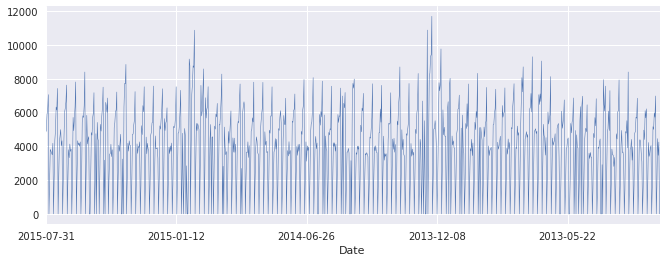

In [8]:
# Visualize Store_ID 5 as an example
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

sales_df_5 = sales_df_5.set_index('Date')
sales_df_5['Sales'].plot(linewidth=0.5);

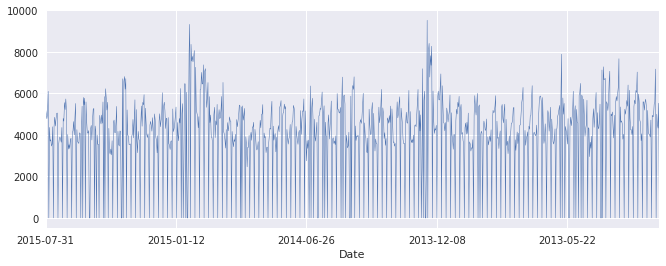

In [9]:
# Visualize Store_ID 1 as an example
sales_df_1 = sales_df[sales_df['Store']==1]
sns.set(rc={'figure.figsize':(11, 4)})
sales_df_1 = sales_df_1.set_index('Date')
sales_df_1['Sales'].plot(linewidth=0.5);

insight:
    
15) there seems to be no upward or downward trend for these stores. No clear seasonality either, although there are peaks around christmas time

# 3. Data Preparation

### 3.1 Cleaning

#### sales_df

In [10]:
# insight 2: the "Date" column needs to be transformed into a timeseries object
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%Y-%m-%d')
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [11]:
# insight 3: the "StateHoliday" column should also be encoded to numerical
# "StateHoliday" values are: a = public holiday, b = Easter holiday, c = Christmas and 0 for no holiday
# I would not differentiate between a,b or c and just encode these as "1" for state holiday
sales_df.loc[sales_df.StateHoliday != 0, 'StateHoliday'] = 1

In [12]:
# I think it will be benefincial to add a unique ID for each datapoint (each combination of store and time)
sales_df['ID'] = sales_df.index
sales_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID
1017204,1111,2,2013-01-01,0,0,0,0,1,1,1017204
1017205,1112,2,2013-01-01,0,0,0,0,1,1,1017205
1017206,1113,2,2013-01-01,0,0,0,0,1,1,1017206
1017207,1114,2,2013-01-01,0,0,0,0,1,1,1017207
1017208,1115,2,2013-01-01,0,0,0,0,1,1,1017208


#### store_df

insight 10): the missings in "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" are due to the fact that Promo2 is not applicable at these stores. Thus instead of NaN I will fill these fields with zero

In [13]:
store_df.Promo2SinceWeek = store_df.Promo2SinceWeek.fillna(0)
store_df.Promo2SinceYear = store_df.Promo2SinceYear.fillna(0)
store_df.PromoInterval = store_df.PromoInterval.fillna(0)
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


insight 12: the missinings in "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" can not be imputed and it wouldn't make sense to fill these with zeros. I don't see why it should make a differnce how long a compeditor has been in the area, the distance to the competition seems much more important. Thus I plan to delete these two columns.

In [14]:
store_df = store_df.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'])

insight 13: "StoreType", "Assortment" and "PromoInterval" need to be converted to numerical features

In [15]:
# change "StoreType" and "Assortment"
store_df['StoreType'] = store_df['StoreType'].astype('category')
store_df['Assortment'] = store_df['Assortment'].astype('category')
category_columns = store_df.select_dtypes(['category']).columns
store_df[category_columns] = store_df[category_columns].apply(lambda x: x.cat.codes)
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 8 columns):
Store                  1115 non-null int64
StoreType              1115 non-null int8
Assortment             1115 non-null int8
CompetitionDistance    1112 non-null float64
Promo2                 1115 non-null int64
Promo2SinceWeek        1115 non-null float64
Promo2SinceYear        1115 non-null float64
PromoInterval          1115 non-null object
dtypes: float64(3), int64(2), int8(2), object(1)
memory usage: 54.5+ KB


insight 11: "Promo2SinceWeek", "Promo2SinceYear" should be converted into a datetime object. 

In [16]:
# change to string and delete tailing ".0"
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].astype(str).str[:-2]
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].astype(str).str[:-2]

In [17]:
# combine the two
store_df['Promo2StartDate'] = store_df['Promo2SinceYear']+'-'+store_df['Promo2SinceWeek']
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2StartDate
0,1,2,0,1270.0,0,0,0,0,0-0
1,2,0,0,570.0,1,13,2010,"Jan,Apr,Jul,Oct",2010-13
2,3,0,0,14130.0,1,14,2011,"Jan,Apr,Jul,Oct",2011-14
3,4,2,2,620.0,0,0,0,0,0-0
4,5,0,0,29910.0,0,0,0,0,0-0


In [18]:
# subset df to only those stores with Promo2
store_df_p2 = store_df.loc[store_df['Promo2'] == 1]

# iterate over all the elements 
sr = store_df_p2['Promo2StartDate']
result = []
for items in sr.iteritems():  
    result.append(datetime.strptime(items[1] + '-1', "%Y-%W-%w").date())

In [19]:
store_df_p2['Promo2StartDate'] = result
store_df_p2.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2StartDate
1,2,0,0,570.0,1,13,2010,"Jan,Apr,Jul,Oct",2010-03-29
2,3,0,0,14130.0,1,14,2011,"Jan,Apr,Jul,Oct",2011-04-04
10,11,0,2,960.0,1,1,2012,"Jan,Apr,Jul,Oct",2012-01-02
11,12,0,2,1070.0,1,13,2010,"Jan,Apr,Jul,Oct",2010-03-29
12,13,3,0,310.0,1,45,2009,"Feb,May,Aug,Nov",2009-11-09


In [20]:
# subset store_df_p2 to columns only relevant for stores with Promo2
store_df_p2 = store_df_p2 [['Store', 'Promo2StartDate', 'PromoInterval']]
store_df_p2.head()

,Store,Promo2StartDate,PromoInterval
1,2,2010-03-29,"Jan,Apr,Jul,Oct"
2,3,2011-04-04,"Jan,Apr,Jul,Oct"
10,11,2012-01-02,"Jan,Apr,Jul,Oct"
11,12,2010-03-29,"Jan,Apr,Jul,Oct"
12,13,2009-11-09,"Feb,May,Aug,Nov"


In [21]:
store_df_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 1 to 1114
Data columns (total 3 columns):
Store              571 non-null int64
Promo2StartDate    571 non-null object
PromoInterval      571 non-null object
dtypes: int64(1), object(2)
memory usage: 17.8+ KB


In [22]:
print(store_df_p2.PromoInterval.unique())

['Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [23]:
# subset store_df to all columns relevant for all stores
store_df = store_df [['Store', 'StoreType', 'Assortment', 'CompetitionDistance']]
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 4 columns):
Store                  1115 non-null int64
StoreType              1115 non-null int8
Assortment             1115 non-null int8
CompetitionDistance    1112 non-null float64
dtypes: float64(1), int64(1), int8(2)
memory usage: 19.7 KB


insight 14: For the 3 rows with a missing "CompetitionDistance" I assume that these stores have no competition in close approximation, thus I plan to impute the values as 99999 (which is represententing a competition far away/ non existent)

In [24]:
store_df.CompetitionDistance = store_df.CompetitionDistance.fillna(99999)

### 3.2 Transformation

In [25]:
# combine store and sales data based on Store column
sales_df['StoreType'] = sales_df.Store.map(store_df.set_index('Store')['StoreType'].to_dict())
sales_df['Assortment'] = sales_df.Store.map(store_df.set_index('Store')['Assortment'].to_dict())
sales_df['CompetitionDistance'] = sales_df.Store.map(store_df.set_index('Store')['CompetitionDistance'].to_dict())
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance
0,1,5,2015-07-31,5263,555,1,1,1,1,0,2,0,1270.0
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570.0
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130.0
3,4,5,2015-07-31,13995,1498,1,1,1,1,3,2,2,620.0
4,5,5,2015-07-31,4822,559,1,1,1,1,4,0,0,29910.0


In [26]:
sales_df['Promo2StartDate'] = sales_df.Store.map(store_df_p2.set_index('Store')['Promo2StartDate'].to_dict())
sales_df['Promo2Interval'] = sales_df.Store.map(store_df_p2.set_index('Store')['PromoInterval'].to_dict())

# 4. Feature Engineering

### 4.1 Combine Features

#### 4.1.1. Find out for each row if Promo2 was active at that "Date" (creating the new feature "Promo_2_active"

insight 11: When combining the two df I will create a new column "Promo_2_active" instead of the 3 columns "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval"

In [27]:
# subset sales_df to a df containing only those store with Promo 2
sales_df['Promo2StartDate'] = sales_df['Promo2StartDate'].fillna(0)
promo2_df = sales_df[sales_df['Promo2StartDate'] != 0]
promo2_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo2StartDate,Promo2Interval
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570.0,2010-03-29,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130.0,2011-04-04,"Jan,Apr,Jul,Oct"
10,11,5,2015-07-31,10457,1236,1,1,1,1,10,0,2,960.0,2012-01-02,"Jan,Apr,Jul,Oct"
11,12,5,2015-07-31,8959,962,1,1,1,1,11,0,2,1070.0,2010-03-29,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,1,0,12,3,0,310.0,2009-11-09,"Feb,May,Aug,Nov"


In [28]:
promo2_df['Promo2StartDate'] = pd.to_datetime(promo2_df['Promo2StartDate'], format='%Y-%m-%d')
promo2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509178 entries, 1 to 1017208
Data columns (total 15 columns):
Store                  509178 non-null int64
DayOfWeek              509178 non-null int64
Date                   509178 non-null datetime64[ns]
Sales                  509178 non-null int64
Customers              509178 non-null int64
Open                   509178 non-null int64
Promo                  509178 non-null int64
StateHoliday           509178 non-null int64
SchoolHoliday          509178 non-null int64
ID                     509178 non-null int64
StoreType              509178 non-null int64
Assortment             509178 non-null int64
CompetitionDistance    509178 non-null float64
Promo2StartDate        509178 non-null datetime64[ns]
Promo2Interval         509178 non-null object
dtypes: datetime64[ns](2), float64(1), int64(11), object(1)
memory usage: 62.2+ MB


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
# subset df further so only those IDs remain where the Date lies after Promo 2 started 
promo2_active = promo2_df[(promo2_df['Date']) >= (promo2_df['Promo2StartDate'])]
promo2_active.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo2StartDate,Promo2Interval
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570.0,2010-03-29,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130.0,2011-04-04,"Jan,Apr,Jul,Oct"
10,11,5,2015-07-31,10457,1236,1,1,1,1,10,0,2,960.0,2012-01-02,"Jan,Apr,Jul,Oct"
11,12,5,2015-07-31,8959,962,1,1,1,1,11,0,2,1070.0,2010-03-29,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,1,0,12,3,0,310.0,2009-11-09,"Feb,May,Aug,Nov"


In [30]:
# extract the month from 'Date' column
promo2_active['Month'] = promo2_active['Date'].apply(lambda x: x.month)

# define dictionary to change numbers to months
month_abbreviations= {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
promo2_active['Month'] = promo2_active.Month.replace(month_abbreviations)

# change 'Month' and 'Promo2Interval' to string type
promo2_active['Month'] = promo2_active['Month'].astype(str)
promo2_active['Promo2Interval'] = promo2_active['Promo2Interval'].astype(str)

# check for each row if the Date month lies within the Promo2Interval
promo2_active['Promo_2_active'] = promo2_active.apply(lambda x: x.Month in x.Promo2Interval, axis=1)

# change true/false to 1/0
mapping= {True:1,False:0}
promo2_active['Promo_2_active'] = promo2_active.Promo_2_active.replace(mapping)

promo2_active.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo2StartDate,Promo2Interval,Month,Promo_2_active
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570.0,2010-03-29,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130.0,2011-04-04,"Jan,Apr,Jul,Oct",Jul,1
10,11,5,2015-07-31,10457,1236,1,1,1,1,10,0,2,960.0,2012-01-02,"Jan,Apr,Jul,Oct",Jul,1
11,12,5,2015-07-31,8959,962,1,1,1,1,11,0,2,1070.0,2010-03-29,"Jan,Apr,Jul,Oct",Jul,1
12,13,5,2015-07-31,8821,568,1,1,1,0,12,3,0,310.0,2009-11-09,"Feb,May,Aug,Nov",Jul,0


In [31]:
# map'Promo_2_active' back to sales_df
sales_df['Promo_2_active'] = sales_df.ID.map(promo2_active.set_index('ID')['Promo_2_active'].to_dict())
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo2StartDate,Promo2Interval,Promo_2_active
0,1,5,2015-07-31,5263,555,1,1,1,1,0,2,0,1270.0,0,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570.0,2010-03-29,"Jan,Apr,Jul,Oct",1.0
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130.0,2011-04-04,"Jan,Apr,Jul,Oct",1.0
3,4,5,2015-07-31,13995,1498,1,1,1,1,3,2,2,620.0,0,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,1,1,4,0,0,29910.0,0,NaN,NaN


In [32]:
# delete "Promo2StartDate" and "Promo2Interval" and fill NaN in 'Promo_2_active' with 0 
sales_df = sales_df.drop(columns=['Promo2StartDate', 'Promo2Interval'])
sales_df['Promo_2_active'] = sales_df['Promo_2_active'].fillna(0)
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Date                   1017209 non-null datetime64[ns]
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int64
SchoolHoliday          1017209 non-null int64
ID                     1017209 non-null int64
StoreType              1017209 non-null int64
Assortment             1017209 non-null int64
CompetitionDistance    1017209 non-null float64
Promo_2_active         1017209 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(11)
memory usage: 108.6 MB


In [33]:
sales_df['Promo_2_active'] = sales_df['Promo_2_active'].astype(int)
sales_df['CompetitionDistance'] = sales_df['CompetitionDistance'].astype(int)
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active
0,1,5,2015-07-31,5263,555,1,1,1,1,0,2,0,1270,0
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570,1
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130,1
3,4,5,2015-07-31,13995,1498,1,1,1,1,3,2,2,620,0
4,5,5,2015-07-31,4822,559,1,1,1,1,4,0,0,29910,0


#### 4.1.2. Combine the information of 'DayOfWeek = 7' with 'Open=1' to a new feature "Open_sunday"

insight 8: there seem to be quite a few open sundays with high sales also. Thus it would be unwise to delete all sundays but maybe this correlation should be extracted more clearly for the model by creating a binary feature like "Open_sunday"

In [34]:
conditions = [(sales_df.DayOfWeek == 7) & (sales_df.Open == 1)]
choices = ['1']

sales_df['Open_sunday'] = np.select(conditions, choices, default='0')
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday
0,1,5,2015-07-31,5263,555,1,1,1,1,0,2,0,1270,0,0
1,2,5,2015-07-31,6064,625,1,1,1,1,1,0,0,570,1,0
2,3,5,2015-07-31,8314,821,1,1,1,1,2,0,0,14130,1,0
3,4,5,2015-07-31,13995,1498,1,1,1,1,3,2,2,620,0,0
4,5,5,2015-07-31,4822,559,1,1,1,1,4,0,0,29910,0,0


In [35]:
#checking outcome
print(sales_df[(sales_df.DayOfWeek == 7) & (sales_df.Open == 1)])

         Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
5659        85          7 2015-07-26  11421       1606     1      0   
5696       122          7 2015-07-26   5773        707     1      0   
5783       209          7 2015-07-26   3742        354     1      0   
5833       259          7 2015-07-26  15998       2857     1      0   
5836       262          7 2015-07-26  32547       4783     1      0   
5848       274          7 2015-07-26   7750       1608     1      0   
5873       299          7 2015-07-26   4865        517     1      0   
5884       310          7 2015-07-26   3159        250     1      0   
5909       335          7 2015-07-26   7988       1509     1      0   
5927       353          7 2015-07-26   9788       1993     1      0   
5997       423          7 2015-07-26  16014       2426     1      0   
6007       433          7 2015-07-26   2143        280     1      0   
6027       453          7 2015-07-26   7455        930     1      0   
6068  

### 4.2 Correlation Matrix to select most important features

insight 4: from this first look at the data, it seems that "Customer" column and "Sales" column are highly correlated. But the Number of Customers is not known for a prediction. Thus I would remove this information before starting the prediction. Maybe it can help though to find a correlation between Customers and Promotions.

Sales        1.000000
Customers    0.894711
Open         0.678472
Name: Sales, dtype: float64


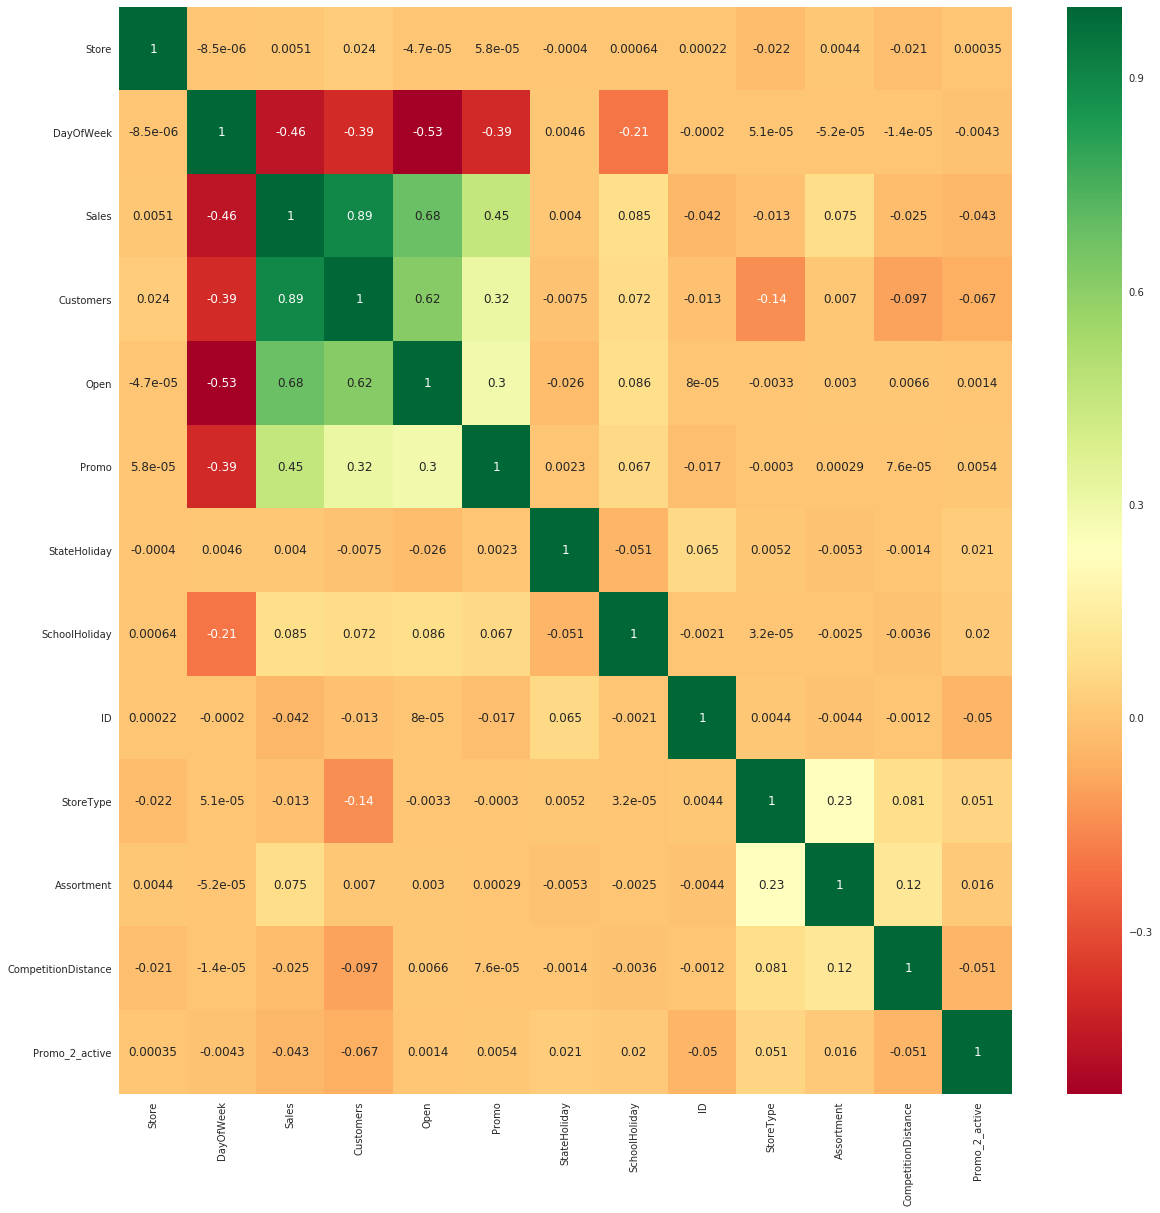

In [36]:
#get correlations 
cor = sales_df.corr()
top_corr_features = cor.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(sales_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
# subsetting the correlations of all features with the target variable
cor_target = abs(cor["Sales"])
# selecting only features with a correlation over 0.1 and under -0.1 with target
best_features = cor_target [cor_target > 0.5]
print(best_features)

Customer and Open have the highest correlation with sales. The Customer column doesn't seem to show insight which the sales column doesn't show directly too. Since the number of customers is not available for the forecast, this column will be deleted for now. 

In [37]:
sales_df = sales_df.drop(columns=['Customers'])

In [38]:
# save sales df to csv ('prepared_data_all.csv') for "part2_DeepAR" notebook

pd.DataFrame(sales_df).to_csv(os.path.join('prepared_data_all.csv'))

### this prepared df is used as input for the Model configuration of the benchmark and deepAR Model

### 4.3 PCA - reducing the number of features 

In order to reduce the number of features, before training a prediction model, a PCA was performed. The following lines give insight to the approach. But I encountered a problem when applying the PCA through a Batch Transform job at Sagemaker which I was not able to solve in time for the project to be handed in. Thus, the follwoing information was not further used for this project.   

In [54]:
sales_df.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday
0,1,5,2015-07-31,5263,1,1,1,1,0,2,0,1270,0,0
1,2,5,2015-07-31,6064,1,1,1,1,1,0,0,570,1,0
2,3,5,2015-07-31,8314,1,1,1,1,2,0,0,14130,1,0
3,4,5,2015-07-31,13995,1,1,1,1,3,2,2,620,0,0
4,5,5,2015-07-31,4822,1,1,1,1,4,0,0,29910,0,0


In [55]:
# drop date since it is a timeseries object
reduced_sales_df = sales_df.drop(columns=['Date'])

In [56]:
# scale numerical features into a normalized range, 0-1
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
# store them in this dataframe
df_scaled=pd.DataFrame(scaler.fit_transform(reduced_sales_df.astype(float)))

# get same features and State-County indices
df_scaled.columns=reduced_sales_df.columns
df_scaled.index=reduced_sales_df.index

df_scaled.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday
0,0.000000,0.666667,0.126664,1.0,1.0,1.0,1.0,0.000000e+00,0.666667,0.0,0.012503,0.0,0.0
1,0.000898,0.666667,0.145941,1.0,1.0,1.0,1.0,9.830831e-07,0.000000,0.0,0.005501,1.0,0.0
2,0.001795,0.666667,0.200091,1.0,1.0,1.0,1.0,1.966166e-06,0.000000,0.0,0.141130,1.0,0.0
3,0.002693,0.666667,0.336815,1.0,1.0,1.0,1.0,2.949249e-06,0.666667,1.0,0.006001,0.0,0.0
4,0.003591,0.666667,0.116050,1.0,1.0,1.0,1.0,3.932332e-06,0.000000,0.0,0.298963,0.0,0.0


In [57]:
# add Date back to df after scaling
df_all_scaled = df_scaled.copy()
df_all_scaled ['Date'] = sales_df['Date']
df_all_scaled ['Store'] = sales_df['Store']
df_all_scaled.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday,Date
0,1,0.666667,0.126664,1.0,1.0,1.0,1.0,0.000000e+00,0.666667,0.0,0.012503,0.0,0.0,2015-07-31
1,2,0.666667,0.145941,1.0,1.0,1.0,1.0,9.830831e-07,0.000000,0.0,0.005501,1.0,0.0,2015-07-31
2,3,0.666667,0.200091,1.0,1.0,1.0,1.0,1.966166e-06,0.000000,0.0,0.141130,1.0,0.0,2015-07-31
3,4,0.666667,0.336815,1.0,1.0,1.0,1.0,2.949249e-06,0.666667,1.0,0.006001,0.0,0.0,2015-07-31
4,5,0.666667,0.116050,1.0,1.0,1.0,1.0,3.932332e-06,0.000000,0.0,0.298963,0.0,0.0,2015-07-31


#### Train/Test Split

In [58]:
# as defined in Proposal: 
# train range 07.01.2013 – 07.06.2015 (94,7% of data)
# test range 08.06.2015-26.07.2015 (5,3% of data) 

# TRAIN
# Filter out all rows with a date past 07.06.2015
df_train = df_all_scaled[df_all_scaled['Date']<'2015-06-08']
# Filter out all rows with a date before 07.01.2013
df_train = df_train[df_train['Date']>='2013-07-01']

# TEST
# Filter out all rows with a date before 08.06.2015
df_test = df_all_scaled[df_all_scaled['Date']>='2015-06-08']
# Filter out all rows with a date past 26.07.2015
df_test = df_test[df_test['Date']<'2015-07-27']

In [59]:
train_x = df_train.drop(columns=['Sales'])
train_y = df_train['Sales']
test_x = df_test.drop(columns=['Sales'])
test_y = df_test['Sales']

PCA is meant to reduce features, not label) therefore I use "train_x" as input data  

In [60]:
# drop date since it is a timeseries object
train_pca = train_x.drop(columns=['Date'])

In [61]:
# define PCA with AWS

# sagemaker libraries
import boto3
import sagemaker
# boto3 client to get S3 data
s3_client = boto3.client('s3')

from sagemaker import get_execution_role
session = sagemaker.Session() # store the current SageMaker session
# get IAM role
role = get_execution_role()
print(role)
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
# define location to store model artifacts
prefix = 'rossmann'
output_path='s3://{}/{}/'.format(bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_path))
# define a PCA model
from sagemaker import PCA
# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=11
pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.p2.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

arn:aws:iam::395339144106:role/service-role/AmazonSageMaker-ExecutionRole-20200303T145130
sagemaker-eu-central-1-395339144106
Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-395339144106/rossmann/


In [48]:
# apply PCA with AWS

# convert df to np array
train_data_np = train_pca.values.astype('float32')
# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)
# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2020-04-12 08:47:51 Starting - Starting the training job...
2020-04-12 08:47:52 Starting - Launching requested ML instances...
2020-04-12 08:48:47 Starting - Preparing the instances for training.........
2020-04-12 08:50:12 Downloading - Downloading input data
2020-04-12 08:50:12 Training - Downloading the training image...
2020-04-12 08:50:46 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[04/12/2020 08:50:38 INFO 139824565421888] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/12/2020 08:50:38 INFO 139824565421888] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u


2020-04-12 08:50:52 Completed - Training job completed
Training seconds: 55
Billable seconds: 55


In [49]:
# accessing the pcs attributes

# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-04-09-20-01-24-667'
# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)
# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

import mxnet as mx
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')
# what are the params
print(pca_model_params)

rossmann/pca-2020-04-09-20-01-24-667/output/model.tar.gz
{'s': 
[7.8145874e+01 1.8390544e+02 2.0126196e+02 3.0696808e+02 3.1030560e+02
 3.2719006e+02 3.4911639e+02 3.5962344e+02 4.6272934e+02 4.8079517e+02
 2.7975403e+05]
<NDArray 11 @cpu(0)>, 'v': 
[[ 5.69835311e-06 -5.36409118e-07  2.66733302e-08 -2.94179449e-06
  -5.49720653e-06  3.59074329e-06 -1.13466217e-06 -2.86801751e-05
   1.16634146e-05 -3.10255999e-08  1.00000000e+00]
 [-2.12054420e-03 -1.13408320e-01  8.15369010e-01 -2.35405996e-01
   2.11638927e-01  8.10340121e-02 -1.74861789e-01  6.05041767e-03
   5.58734266e-03 -4.29194659e-01 -1.45153640e-08]
 [-2.76509649e-03 -9.93737653e-02  5.25238574e-01  5.58546245e-01
  -4.23305064e-01 -6.85775746e-03  1.59408137e-01  1.17877154e-02
  -4.33901651e-03  4.43994224e-01 -1.41881671e-07]
 [ 1.84600765e-04  1.63698252e-02  1.22217245e-01 -3.72114301e-01
   3.10189575e-01  1.10643208e-01 -3.90842438e-01  6.73018163e-03
  -1.07413502e-02  7.64813066e-01  1.18575855e-07]
 [-1.80051706e-04 

In [50]:
# check how many components lead to how much variance of the data

# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [51]:
# test cell
# calculate the explained variance
for i in range (1,(N_COMPONENTS)):
    exp_variance = explained_variance(s, i)
    print('Explained variance of ', i ,'components:', exp_variance)

Explained variance of  1 components: 0.9999863
Explained variance of  2 components: 0.9999892
Explained variance of  3 components: 0.99999195
Explained variance of  4 components: 0.9999936
Explained variance of  5 components: 0.9999952
Explained variance of  6 components: 0.99999654
Explained variance of  7 components: 0.9999978
Explained variance of  8 components: 0.9999989
Explained variance of  9 components: 0.99999946
Explained variance of  10 components: 0.9999999


In [52]:
# component composition

import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

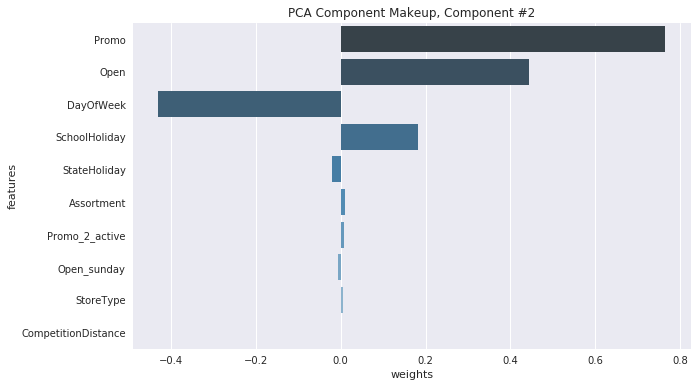

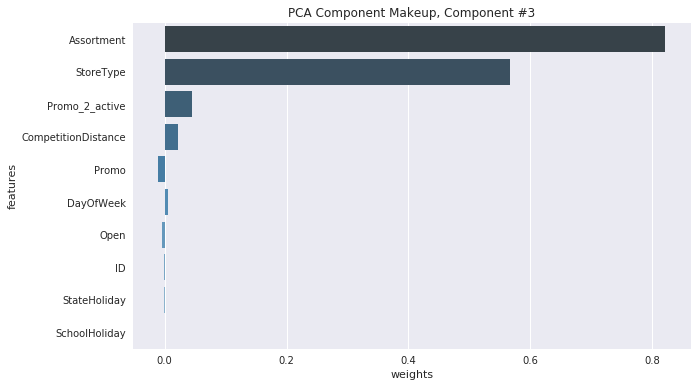

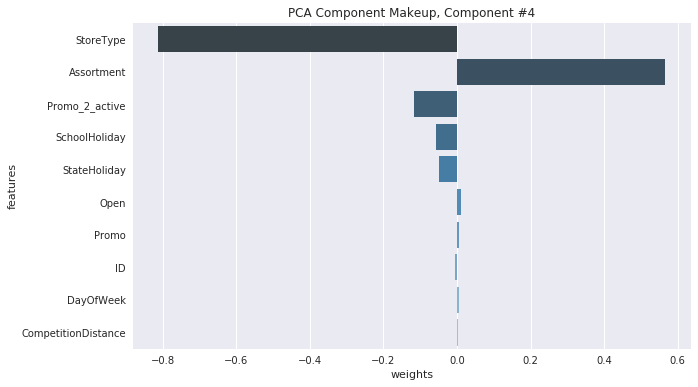

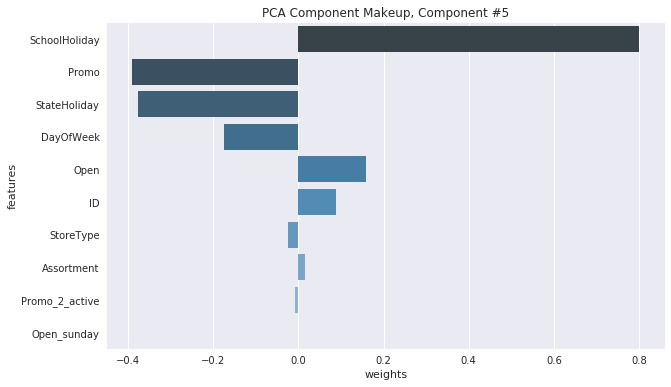

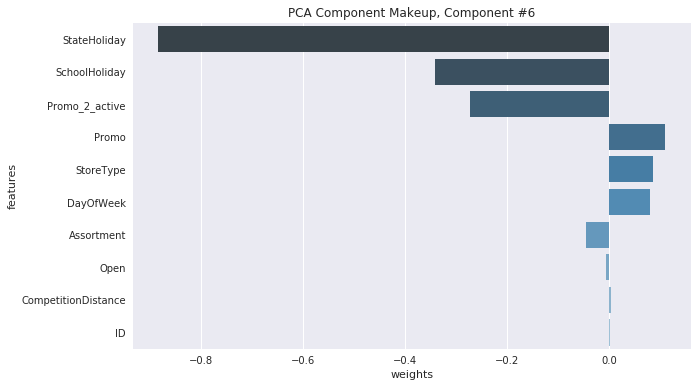

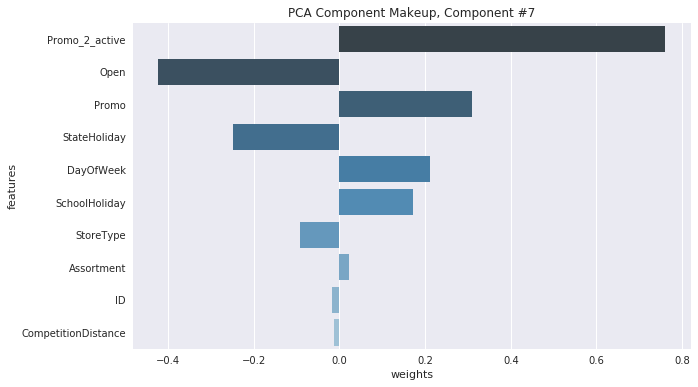

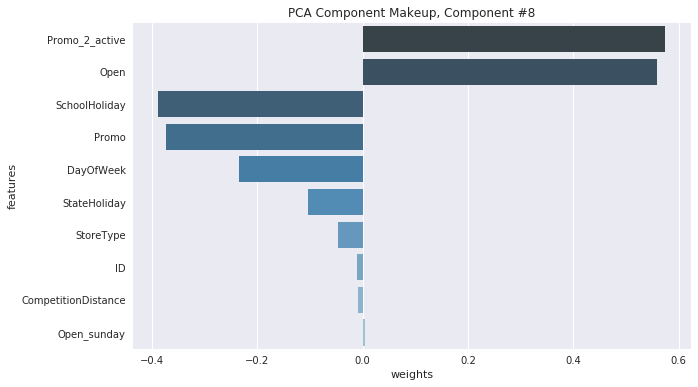

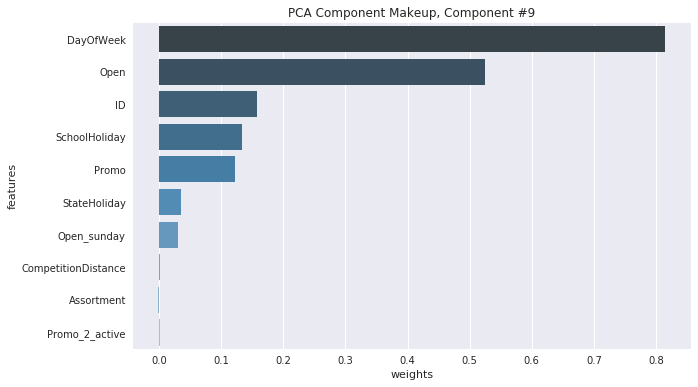

In [62]:
# display makeup of first component
for i in range (2,10):
    display_component(v, train_pca.columns.values, component_num=i, n_weights=10)

#### PCA Batch transform (because the data is too big for instant deployemnt) 

In [ ]:
# save "formatted_train_data"
pd.DataFrame(train_data_np).to_csv(os.path.join('pca_input.csv'))

# save to s3 
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix='deepar-rossmann'

# *unique* prefix
input_prefix   = '{}/{}'.format(prefix, 'pca_data')

# uploading data to S3, and saving locations
pca_path = sagemaker_session.upload_data('pca_input.csv', bucket=bucket, key_prefix=input_prefix)

# check locations
print('Prediction input data is stored in: '+ pca_path)

In [ ]:
# have to change data to record set for pca?

In [ ]:
pca_transformer = pca_SM.transformer(instance_count=1,
                                  instance_type='ml.m4.xlarge',
                                  strategy='SingleRecord',
                                  assemble_with='Line',
                                  output_path='s3://{}/{}/pca/transform/out'.format(bucket, prefix))

In [ ]:
pca_transformer.transform(pca_path, content_type='application/jsonlines', split_type='Line')
pca_transformer.wait()